## Поиск ближайших

Сформулируем задачу следующим образом: имеется большой набор объектов, описываемых векторами R^n; требуется построить такую структуру данных, которая по вектору R^n (объекту, называемому запросом) вернет K ближайших (по некоторой метрике, i.e. L2, cosine) объектов из набора.

Таким образом, имеем исходную параметризацию: размер набора, размер пространства представления (n), размер ответа (K), метрика.

Задачу можно решать как точно, так и приблизительно, разменивая точность на скорость.

В качестве данных используем mnist 8m.

In [1]:
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/mnist8m.bz2
! bzip2 -vd mnist8m.bz2

--2022-03-26 11:49:09--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/mnist8m.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2962365579 (2.8G) [application/x-bzip2]
Saving to: ‘mnist8m.bz2’

mnist8m.bz2         100%[===================>]   2.76G  11.2MB/s    in 4m 1s   

2022-03-26 11:53:11 (11.7 MB/s) - ‘mnist8m.bz2’ saved [2962365579/2962365579]

  mnist8m.bz2: done


In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import BallTree

Для семинара отрежем семпл, чтобы не ждать особенно долго.

In [1]:
! head -n 50000 mnist8m > mnist_sample

In [5]:
X, y = load_svmlight_file('mnist_sample', n_features=784)

In [6]:
X = X / 255  # отмасштабируем

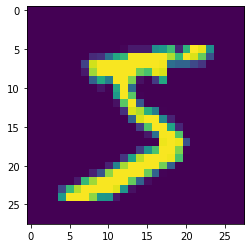

In [7]:
plt.imshow(X[0].reshape(28, 28).toarray())

Итого, у нас целая куча картинок. Наша задача - по полученной картинке найти самые похожие на нее.

Каждая картинка в нашем случае - это просто вектор из R^784. Таким образом будем пытаться искать близкие между собой вектора по какой-то метрике. 

Note: искать в пространстве пикселей может быть не самой разумной идеей - можно получить гораздо более качественные результаты, если предобработать сырые данные (посчитать какие-то умные фичи по картинке, например), однако в конце остается задача - как по вектору из R^d искать близкие к нему. Именно эту задачу мы и попытаемся решить. Вопрос эмбединга исходных данных остается за рамками этого курса, поэтому для наших целей исходные данные вполне подойдут.


# Ball Tree

Одним из простых и понятных алгоритмов поиска ближайших соседей в метрическом пространстве является алгоритм Ball Tree.

Идея буквально следующая - разделить все пространство объектов на подобласти, чтобы при поиске ответа необходимо было искать лишь в ограниценных подобластях, а не среди всех объектов.

Простая версия алгоритма Ball Tree строит бинарное дерево, где каждый узел отвечает за свою сферу (гиперсферу), внутри которой находятся другие подсферы. В узлах дерева находятся уже исходные элементы.

Схема построения следующая:
* В корне помещаем одну гиперсферу, которая вмещает в себя вообще все элементы
* После этого на каждом уровне будем разделять элементы внутри гиперсферы на две группы и накрывать их гиперсферами поменьше
  * Самый простой алгоритм разделения ищет точку X - самая дальняя точка от центра текущей сферы, точку Y - самую дальнюю точку от X и далее делит на две группы в зависимости от того к какой точке ближе - X или Y
  * Более продвинутая версия алгоритма считает главные компоненты и делит множество поровну вдоль оси первой главной компоненты - то есть вдоль оси с наибольшей дисперсией.
* Критерии остановки могут быть разными - глубина дерева, количество оставшихся элементов и тд.

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/ball-tree-construct.png">

На рисунке алгоритм определил A и B как самые удаленные точки и относительно них разбил на два подмножества и накрыл их сферами

<img src="http://stevehanov.ca/blog/balltree.png">

Поиск точки близкой по радиусу практически тривиален:
* Нам дается точка `x` и радиус `r`. Мы смотрим на гиперсферу `s`. Если `radius(s) + r > |center(s) - x|`, то это означает, что сфера поиска и наша сфера в дереве не пересекаются, а значит в этой сфере нет смысла искать соседей. Если же `radius(s) + r <= |center(s) - x|`, то сферы пересекаются, значит там могут быть соседи. 
* Используя этот критерий, спускаемся по дереву вниз - когда добираемся до листов просто проверяем все элементы в этом листе на близость к `x`. 
* Возвращаем все те, которые были близко. 

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/ball-tree-search.png">

Итого, дерево позволяет относительно быстро искать соседей (в смысле L2 меры) для заданного радиуса.

Более подробно о структуре данных можно почитать здесь - https://www.researchgate.net/publication/283471105_Ball-tree_Efficient_spatial_indexing_for_constrained_nearest-neighbor_search_in_metric_spaces 

Реализовывать самостоятельно мы его не будем - просто воспользуемся реализацией из sklearn.

In [8]:
%%time
tree = BallTree(X.toarray(), leaf_size=12000)

CPU times: user 22.6 s, sys: 346 ms, total: 22.9 s
Wall time: 22.8 s


In [13]:
def find_nn_ball_tree(index):
    plt.figure()
    plt.imshow(X[index].reshape(28, 28).toarray())
    
    result = tree.query_radius(np.array(X[index].toarray()), r=7)
    print("Neighbours count: ", len(result[0]))
    for nn_index in result[0][:5]:
        plt.figure()
        plt.imshow(X[nn_index].reshape(28, 28).toarray())

Neighbours count:  48


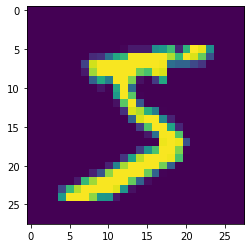

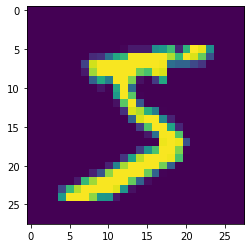

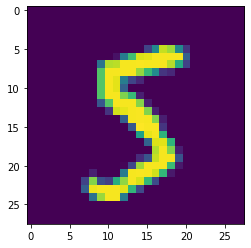

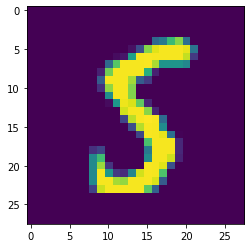

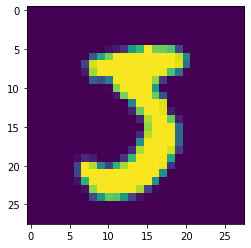

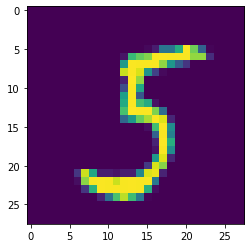

In [14]:
find_nn_ball_tree(0)

Neighbours count:  313


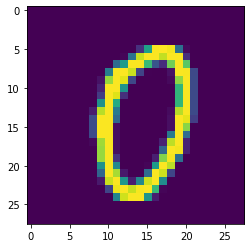

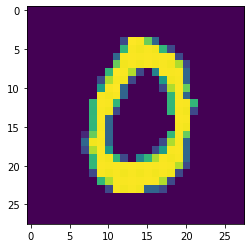

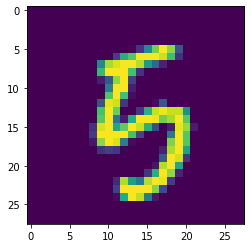

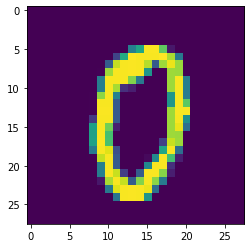

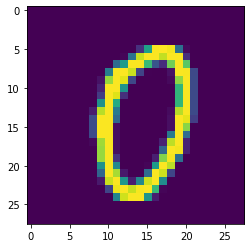

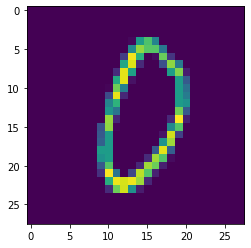

In [15]:
find_nn_ball_tree(1000)

Neighbours count:  44


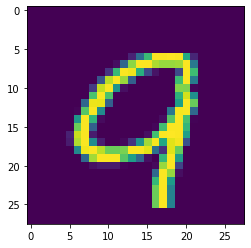

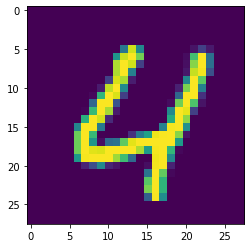

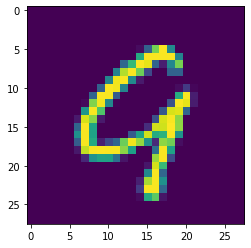

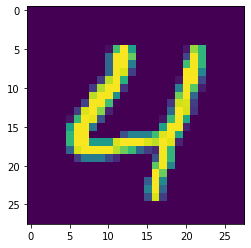

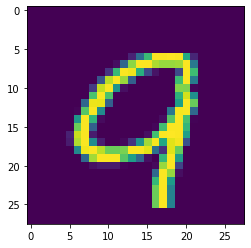

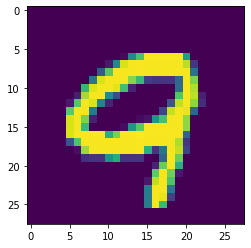

In [16]:
find_nn_ball_tree(3000)

Что ж, кажется, что поиск с радиусом 7 дает вполне осмысленные результаты даже на сырых пикселях!

Однако даже на таком количестве данных такой алгоритм начинает проседать по производительности (попробуйте построить ball tree на всех 8 миллионах). Однако алгоритм всегда выдает корректный (честный) ответ.

Попробуем пойти другим путем и разменять точность ответа на производительность.

# LSH - Locality-sensitive hashing

Интуиция из классических алгоритмов подсказывает нам, что для того чтобы искать очень быстро нужно строить хеш-таблицу. 

Именно этим мы и попытаемся заняться. В идеале мы бы хотели построить хеш с таким свойством, что у близких элементов он бы совпадал. Тогда если мы сложим их в хеш-таблицу, то по одному ключу мы сразу вычислим всех соседей. 

Для того чтобы построить такой хеш, посмотрим немного на R^2.

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/lsh-1.png">

На картинке у нас есть w_1 - базисный вектор (1, 0) и 6 векторов для примера.

Несложный факт из линейной алгебры: скалярное произведение <x, y> в общем случае - это произведение длины вектора x на длину проекции y на вектор x.

<img width="300" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Scalar-product-dot-product.svg/1280px-Scalar-product-dot-product.svg.png">

В случае с базисным вектором w_1 ситуация еще проще - это просто длина проекции на ось Х.

Используя это знание попробуем сконструировать хеш следующего вида

`h(x) = ⌊<x, w_1>⌋` (округляем вниз).

Можно заметить, что все элементы, у которых координата x была в пределах [0, 1] будут иметь один и тот же хеш = 0. Все элементы, у которых x координата в [1, 2] получают одинаковый хеш = 1 и так далее. Другими словами все множество разбивается на такие группы (бакеты) в виде полос (на рисунке показаны две полосы - синяя и серая).

Уже в такой простой постановке хеш может быть полезен. Близкие между собой элементы x_1 и x_2 имеют один и тот же хеш, также как и элементы x_5, x_4.

Однако на картинке сразу видно несколько проблем:
* x_6 находится далеко от x_1, однако имеет с ним такой же хеш.
* x_3 находится близко от x_2, однако они имеют различный хеш.

Давайте их решим. 

Первую проблему можно решить достаточно несложным образом - добавим второй базисный вектор w_2 и под хешом будем уже понимать пару чисел: `h(x) = (⌊<x, w_1>⌋, ⌊<x, w_2>⌋)`

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/lsh-2.png">

Видно, что теперь мы поделили пространство уже не на полосы, а на квадраты, которые задают нам базисные вектора.

Теперь x_1 и x_2 все еще имеют одинаковый хеш = (0, 0) (так же как и x_5 и x_4 с хешом (1, -1)), а вот x_1 и x_6 больше нет - h(x_1) = (0, 0), h(x_6) = (0, 2).

Чтобы решить вторую проблему, мы можем немного подвигать сетку, которая у нас получилась, таким образом, чтобы в подвинутой сетке x_2 и x_3 все таки попали в одну клетку. Для этого нужно завести еще хеш.

`h_2(x) = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2>⌋)`

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/lsh-3.png">

Отлично! Видно, что теперь x_2 и x_3 будут иметь одинаковый хеш. Интересно отметить, что после сдвига x_5 и x_4 имеют различных хеш.

Таким образом для поиска всех соседей потребуется искать соседей по двум хешам - h и h_2.

Необходимо также заметить, что мы сдвинули сетку только по оси x. По оси Y у нас присутствует та же проблема, которую можно решить таким же способов. Легко понять, что для размерности 2, нам потребуется 4 хеша.

* `h_1 = (⌊<x, w_1>⌋, ⌊<x, w_2>⌋)`
* `h_2 = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2>⌋)`
* `h_3 = (⌊<x, w_1>⌋, ⌊<x, w_2> + 0.5⌋)`
* `h_4 = (⌊<x, w_1> + 0.5⌋, ⌊<x, w_2> + 0.5⌋)`

Отлично! Построив 4 таблицы мы можем за константу находить элементы, которые находятся друг от друга на расстоянии меньше 1.

Что делать, если хотим искать с другим радиусом r?

Для этого на самом деле достаточно просто увеличить сетку в r раз - или, что тоже самое, сжать все вектора в r раз. Единственное - необходимо быть аккуратным и сдвигать теперь не на 0.5 а на половину радиуса.

Итого, для радиуса r:

* `h_1 = (⌊<x, w_1> / r⌋, ⌊<x, w_2> / r⌋)`
* `h_2 = (⌊(<x, w_1> + 0.5 * r) / r⌋, ⌊<x, w_2> / r⌋)`
* `h_3 = (⌊<x, w_1> / r⌋, ⌊(<x, w_2> + 0.5 * r) / r⌋)`
* `h_4 = (⌊(<x, w_1> + 0.5 * r) / r⌋, ⌊(<x, w_2> + 0.5 * r) / r⌋)`

Кажется, что критических проблем более не наблюдается. Для R^2 алгоритм будет выглядеть так

* Берем 4 хеша и строим по ним хеш-таблицы для всех элементов
* Когда к нам приходит запрос считаем все 4 хеша и ищем во всех таблицах элементы.
* Дополнительно нужно выкинуть элементы, которые дальше от нашего элемента чем на r. Такое может случиться, так как внутри квадрата элементы могут находится на расстоянии sqrt(2) * r. 

Готово, мы нашли всех соседей, причем наш ответ честный. 

Однако, что произойдет, когда нам потребуется решить эту задачу в R^n, где n - большое.

Если следовать описанной схеме, то нам потребуется взять 2^n хешей, внутри которых будет n элементов. Итого `2^n * n` - это очень много и использовать такую схему as-is крайне непрактично. Эту проблему нам помогут обойти вероятностные трюки.

Предлагается сделать буквально следующее - накидать случайных сеток на пространство таким образом, чтобы вероятность успеха была хорошей. Итого для R^n:

* `h_1 =(⌊(<x, w_11> + b_11) / r⌋, ⌊(<x, w_12> + b_12) / r⌋, ..., ⌊(<x, w_1k> + b_1k) / r⌋ )`
* `h_2 =(⌊(<x, w_21> + b_21) / r⌋, ⌊(<x, w_22> + b_22) / r⌋, ..., ⌊(<x, w_2k> + b_2k) / r⌋ )`
* `...`
* `h_d =(⌊(<x, w_d1> + b_d1) / r⌋, ⌊(<x, w_d2> + b_d2) / r⌋, ..., ⌊(<x, w_dk> + b_dk) / r⌋ )`

`k` - размерность хеша, k < n. `d` - количество хешей, d < 2^n. При этом: `w_ij`- случайный вектор размера n, `b_ij` - случайное число.

Осталось только выбрать параметры так, чтобы вероятность успеха была хорошей. Перед этим неплохо бы понять, что такое вероятность успеха. 

Легко видеть, что у нас могут возникать две проблемы
* Мы можем найти элемент, который на самом деле далеко от нас
* Мы можем не найти элемент, который на самом деле близко от нас

Итого, у нас есть две вероятности - вероятность того, что найденный элемент близок к нам (`alpha_probability`) и вероятность того, что близкий элемент не был нами найден (`beta_probability`). 

Математика утверждает следующее:

Для фиксированных вероятностей `alpha_probability`, `beta_probability`, радиуса `r`, выборки данных размера `M` из `R^n` и меры расстояния `L2`:
* `w_ij` - случайный вектор из нормального распределения `N(0, 1)`
* `b_ij` - случайное число из равномерного распределения `U[0, r]`
* 
```
rho = ln(1/alpha_probability) / ln(1/beta_probability)
k = ceil( ln(M) / ln( 1/beta_probability ) )
d = ceil( 2 * M^rho )
```

Более подробно с алгоритмом можно ознакомиться здесь - https://arxiv.org/pdf/1408.2927.pdf

In [17]:
from collections import defaultdict
from scipy import sparse
from sklearn.metrics import pairwise_distances

class L2LSH():
    def __init__(self, data, radius, alpha_probability=0.9, beta_probability=0.1, seed=42):
        self.data = data
        self.d_shape = data.shape
        self.radius = radius
        
        self.rho = np.log(1 / alpha_probability) / np.log(1 / beta_probability)
        self.k = int(np.ceil(np.log(self.d_shape[0]) / np.log(1 / beta_probability)))
        self.d = int(np.ceil(2 * self.d_shape[0]**self.rho))
        
        np.random.seed(42)
        self.w = np.random.normal(size=(self.d, self.k, self.d_shape[1]))
        self.b = np.random.uniform(0, radius, size=(self.d, self.k))
        
        self.hash_table = self._precompute_hash_table(data)
        
    def _to_1d_arr(self, x):
        if isinstance(x, sparse.csr.csr_matrix):
            x = x.toarray()
        if len(x.shape) > 1:
            x = x[0]
        assert x.shape == (self.d_shape[1],)
        return x
    
    def _hash(self, x):
        hashes = np.floor((self.w @ self._to_1d_arr(x) + self.b) / self.radius)
        return [tuple(vec) for vec in hashes]
        
    def _precompute_hash_table(self, data):
        ht = [defaultdict(list) for _ in range(self.d)]
        for idx, x in enumerate(data):
            for i, j in enumerate(self._hash(x)):
                ht[i][j].append(idx)
        return ht
    
    def find_nn(self, element, k=5, n_jobs=None):
        nn = []
        x = self._to_1d_arr(element)
        for i, j in enumerate(self._hash(element)):
            prob_nn = np.array(self.hash_table[i].get(j, []))
            if not len(prob_nn):
                continue
            dsts = pairwise_distances(self.data[prob_nn], [x], n_jobs=n_jobs)[:, 0]
            idx = np.nonzero(dsts <= self.radius)
            nn.extend(prob_nn[idx][:k - len(nn)])
            if len(nn) == k:
                return nn
        return nn
    
    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[:5]:
            plt.figure()
            plt.imshow(self.data[nn].reshape(28, 28).toarray())

In [18]:
lsh = L2LSH(X, 7)

Neighbours count:  4


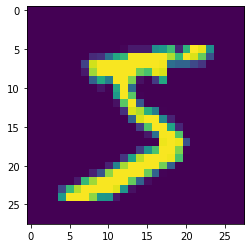

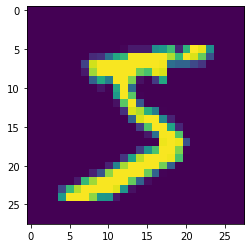

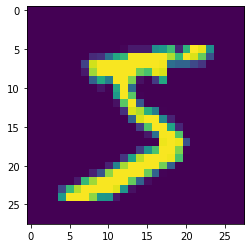

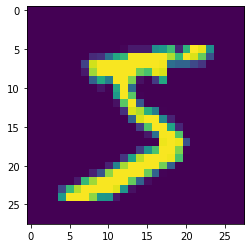

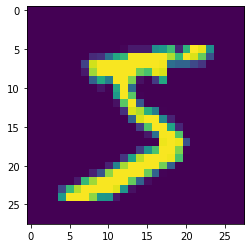

In [19]:
lsh = L2LSH(X, 7)
lsh.find_and_print_nn(X[0])

Neighbours count:  5


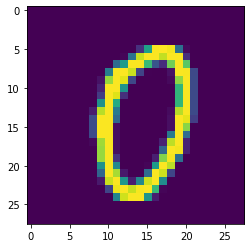

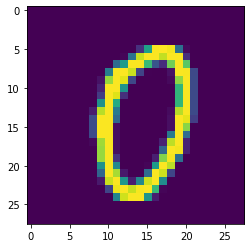

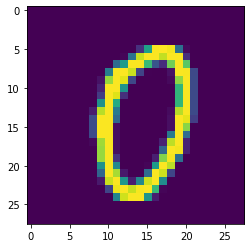

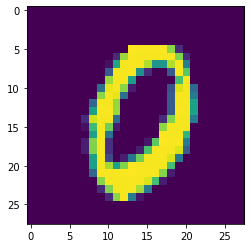

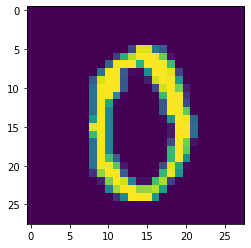

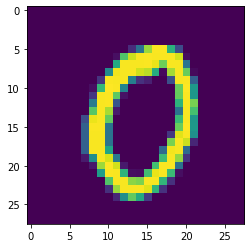

In [20]:
lsh.find_and_print_nn(X[1000])

Neighbours count:  5


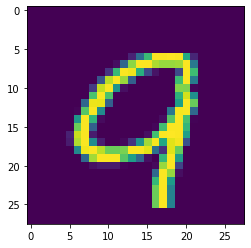

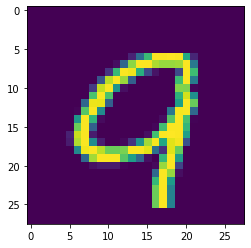

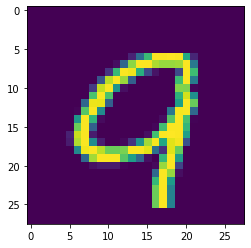

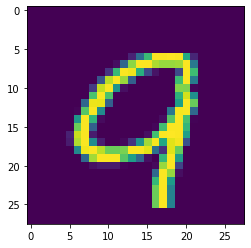

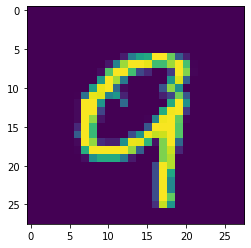

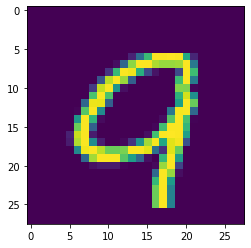

In [21]:
lsh.find_and_print_nn(X[3000])

# LSH для cosine similarity

L2 - не всегда удачная метрика близости. Часто вместо нее используют cosine метрику, которая учитывает только угол между векторами. Как искать вектора, близкие в смысле коллинеарности?

Для этого мы можем провернуть похожий трюк с хешированием и построить LSH для cosine. Рассуждения будут очень похожими.

Note: `cosine(x, y) = 1 - cos(x, y)`

Элементарный хеш будет строится следующий образом

`h(x) = sign(<x, w>)`

Составной хеш будет строится аналогично 

`h_1(x) = (sign(<x, w_1>), sign(x, w_2))`

Если в качестве w_1 и w_2 взять базисные вектора, то картина будет примерно следующей

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/lsh-4.png">

Знак скалярного произведения показывает, "смотрят ли" вектора в одну сторону. Таким образом один вектор делит пространство на две части прямой (гиперплоскостью в общем случае), перпендикулярной этому вектору.

Таким образом, если за `w_i` брать базисные вектора, то одинаковый хеш будут иметь те вектора, которые находятся в одной координатной четверти, что в соотносится с тем, что мы хотели. Такие вектора могут отличатся по L2 на любое расстояние, однако угол между ними не может быть больше 90 градусов (а значит и по косинусу они достаточно близки).

Проблемы при таком построении примерно такие же, как и для L2 и решать их предлагается такими же способами: накидываем случайных сеток.

* `h_1 =(sign(<x, w_11>), sign(<x, w_12> ), ..., sign(<x, w_1k>) )`
* `h_1 =(sign(<x, w_21>), sign(<x, w_22> ), ..., sign(<x, w_2k>) )`
* `...`
* `h_d =(sign(<x, w_d1>), sign(<x, w_d2>), ..., sign(<x, w_dk>) )`

`k` - размерность хеша, k < n. `d` - количество хешей, d < 2^n. При этом: `w_ij`- случайный вектор из `N(0, 1)` размера n.

Более подробно с алгоритмом можно ознакомиться здесь - https://www.hpl.hp.com/techreports/2007/HPL-2007-192R1.pdf

<img src="https://raw.githubusercontent.com/ADKosm/lsml-seminars-2020-public/master/img/lsh-5.png">

In [22]:
from sklearn.neighbors import NearestNeighbors

In [23]:
neigh = NearestNeighbors(metric='cosine')
neigh.fit(X.toarray())

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [24]:
def find_nn_sklearn(index):
    plt.figure()
    plt.imshow(X[index].reshape(28, 28).toarray())
    
    result = neigh.radius_neighbors(np.array(X[index].toarray()), 0.3)
    print("Neighbours count: ", len(result[1][0]))
    for nn_index in result[1][0][:5]:
        plt.figure()
        plt.imshow(X[nn_index].reshape(28, 28).toarray())

Neighbours count:  204


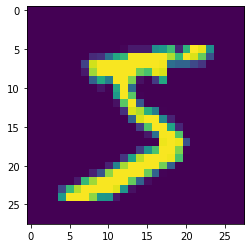

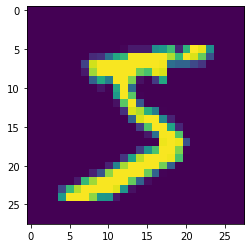

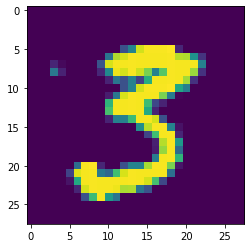

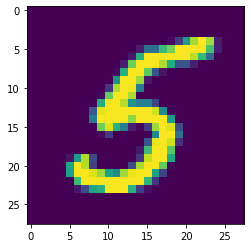

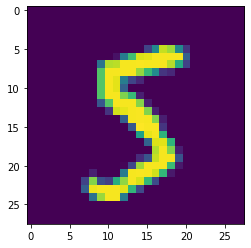

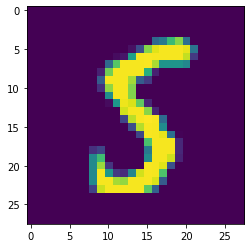

In [25]:
find_nn_sklearn(0)

Neighbours count:  578


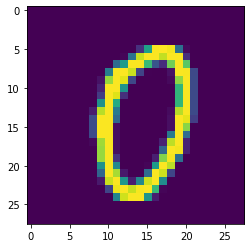

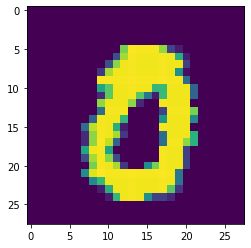

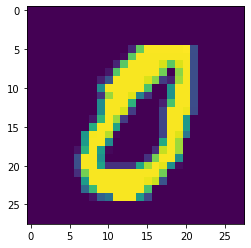

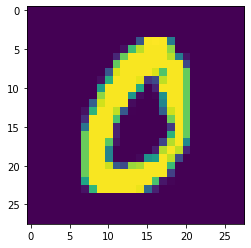

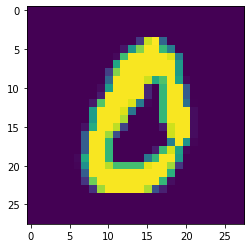

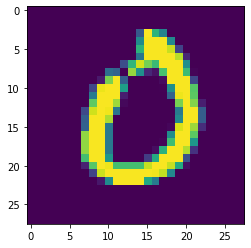

In [26]:
find_nn_sklearn(1000)

Neighbours count:  86


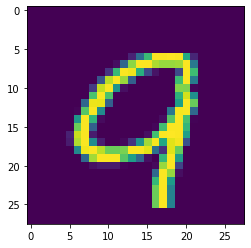

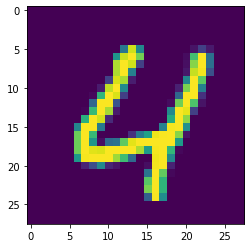

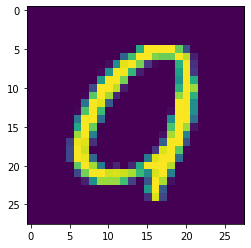

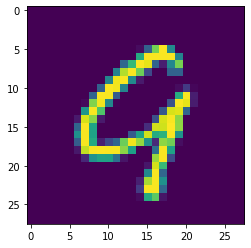

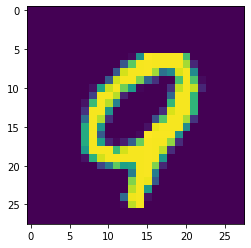

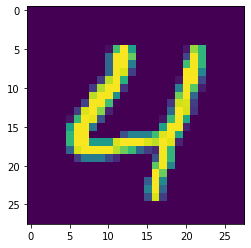

In [27]:
find_nn_sklearn(3000)

In [28]:
class CosineLSH():
    def __init__(self, data, radius, d=15, k=10, seed=42):
        self.data = data
        self.d_shape = data.shape
        self.radius = radius
        self.d = d
        self.k = k
        
        np.random.seed(42)
        self.w = np.random.normal(size=(self.d, self.k, self.d_shape[1]))
        
        self.hash_table = self._precompute_hash_table(data)
        
    def _to_1d_arr(self, x):
        if isinstance(x, sparse.csr.csr_matrix):
            x = x.toarray()
        if len(x.shape) > 1:
            x = x[0]
        assert x.shape == (self.d_shape[1],)
        return x
    
    def _hash(self, x):
        return [tuple(vec) for vec in np.sign(self.w @ self._to_1d_arr(x))]
        
    def _precompute_hash_table(self, data):
        ht = [defaultdict(list) for _ in range(self.d)]
        for idx, x in enumerate(data):
            for i, j in enumerate(self._hash(x)):
                ht[i][j].append(idx)
        return ht
    
    def find_nn(self, element, k=5):
        nn = []
        x = self._to_1d_arr(element)
        for i, j in enumerate(self._hash(element)):
            prob_nn = np.array(self.hash_table[i].get(j, []))
            if not len(prob_nn):
                continue
            dsts = pairwise_distances(self.data[prob_nn], [x])[:, 0]
            idx = np.nonzero(dsts <= self.radius)
            nn.extend(prob_nn[idx][:k - len(nn)])
            if len(nn) == k:
                return nn
        return nn
    
    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[:5]:
            plt.figure()
            plt.imshow(self.data[nn].reshape(28, 28).toarray())

In [29]:
%%time
lsh = CosineLSH(X, 7)

CPU times: user 9.47 s, sys: 5.15 ms, total: 9.48 s
Wall time: 9.48 s


Neighbours count:  5


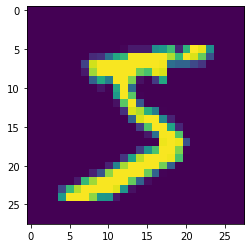

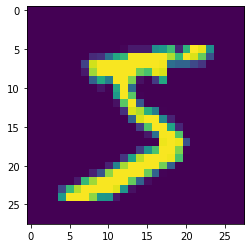

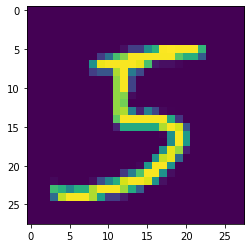

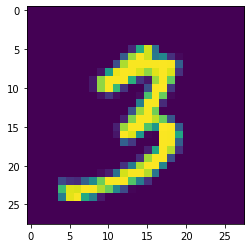

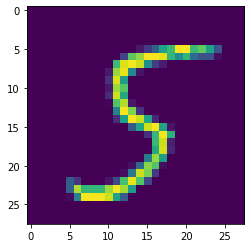

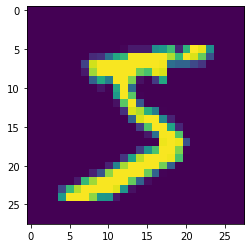

In [30]:
lsh.find_and_print_nn(X[0])

Neighbours count:  5


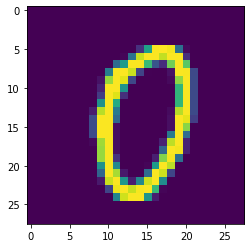

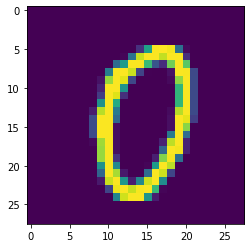

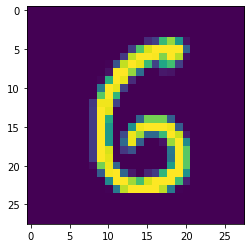

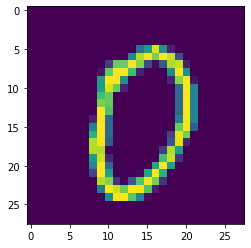

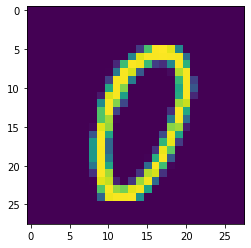

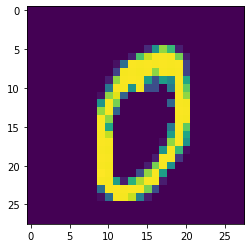

In [31]:
lsh.find_and_print_nn(X[1000])

Neighbours count:  5


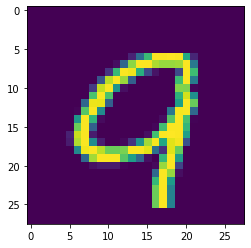

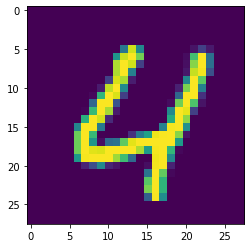

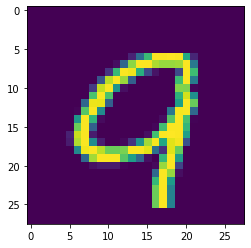

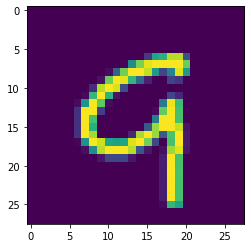

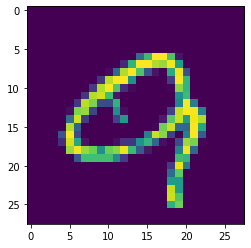

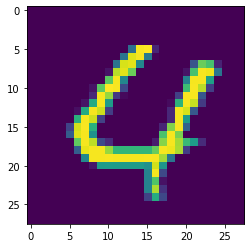

In [32]:
lsh.find_and_print_nn(X[3000])

In [33]:
def precision_recall(y_pred, y_true):
    y_pred, y_true = set(list(y_pred)), set(list(y_true))
    tp = len(y_pred & y_true)
    return tp / len(y_pred), tp / len(y_true)

def knn_precision_recall(gt_knn, pred_knn, samples_size=20, seed=42):    
    np.random.seed(seed)
    precs = []
    recs = []

    for idx in np.random.choice(X.shape[0], size=samples_size, replace=False):
        y_true = gt_knn.query_radius(X[idx].toarray(), 7)[0]
        y_pred = pred_knn.find_nn(X[idx], k=len(y_true))
        prec, rec = precision_recall(y_pred, y_true)
        precs.append(prec)
        recs.append(rec)
    return np.mean(precs), np.mean(recs)

In [34]:
print('Precision {}, Recall {}'.format(*knn_precision_recall(tree, lsh, samples_size=100)))

Precision 1.0, Recall 0.5715830137547129


In [35]:
from time import time

for d in [4, 16, 32]:
    for k in [4, 16, 32]:
        start = time()
        clsh = CosineLSH(X, 7, d=d, k=k)
        elapsed_time = time() - start
        p, r = knn_precision_recall(tree, clsh)
        
        print(f'CosineLSH with d={d}, k={k}')
        print(f'• Creation time {elapsed_time}s')
        print(f'• Precision {p}, Recall {r}')
        print()

CosineLSH with d=4, k=4
• Creation time 4.016742706298828s
• Precision 1.0, Recall 0.7879479466403432

CosineLSH with d=4, k=16
• Creation time 9.880210638046265s
• Precision 1.0, Recall 0.15353074270449205

CosineLSH with d=4, k=32
• Creation time 13.122104406356812s
• Precision 1.0, Recall 0.08704165021072856

CosineLSH with d=16, k=4
• Creation time 6.352973937988281s
• Precision 1.0, Recall 0.7879479466403432

CosineLSH with d=16, k=16
• Creation time 23.461862564086914s
• Precision 1.0, Recall 0.31689795524724723

CosineLSH with d=16, k=32
• Creation time 31.347487211227417s
• Precision 1.0, Recall 0.09480710503430806

CosineLSH with d=32, k=4
• Creation time 11.136168241500854s
• Precision 1.0, Recall 0.7879479466403432

CosineLSH with d=32, k=16
• Creation time 37.50341463088989s
• Precision 1.0, Recall 0.42734564286526516

CosineLSH with d=32, k=32
• Creation time 52.35171461105347s
• Precision 1.0, Recall 0.10579953987663382



В одной из самых первых ячеек этого ноутбука мы мерили время создания ball tree, и оно было довольно большим: примерно час для 500k данных. Как мы видим, CosineLSH справляется с этим намного лучше: ему достаточно нескольких минут на том же обхеме данных.

Теперь перейдем к анализу метрик. Из представленных выше запусков с разными параметрами CosineLSH видно, что ball tree почти всегда находит всех соседей, которых нашел CosineLSH, что дает precision 1. Однако, в обратную сторону это неверно, поэтому recall изменяется в зависимости от параметров CosineLSH. Зависимость тут следующая: с увеличением d recall растет, так как у нас становится больше хешей, и поэтому больше вероятность набрать соседей из разных хешей, обратная ситуация с k: чем больше размерность хеша, тем менее вероятно, что элемент попадет ко всем своим соседям.

По нашему субъективному мнению, CosineLSH работает очень даже хорошо, при небольшом количестве соседей, которых надо найти, он справляется идеально, цифры находит те, что нужно или же очень похожие на них.

## K-Means

Заметим, что в случае с LSH мы некоторым образом кластеризировали данные, а затем искали ближайших в полученных кластерах. На самом деле существует множество комбинаций алгоритмов кластеризации и построения индекса на результате для поиска ближайших.

Сейчас поговорим про кластеризацию: самым популярным методом кластеризации для L2 метрики является k-means. Можно отметить, что он очень хорошо ложится на парадигму MapReduce.

Алгоритм очень прост: мы задаём количество кластеров, на которое хотим поделить данные, а затем итеративно обновляем центры кластеров с целью минимизировать суммарное квадратичное отклонение точек кластеров от этих центров:

![Optimization](https://wikimedia.org/api/rest_v1/media/math/render/svg/fb52bff2fc86ae00cbbf79ff2759bd3e90824bea)

где k — число кластеров, S_i — полученные кластеры, i=1,2,...,k, а mu_i — центры масс всех векторов x из кластера S_i.

Алгоритм может выполняться с ограничением на количество итераций или смещение центров.

Простейшая реализация выглядит примерно так:
1. Инициализируем центры некоторым образом
2. Присваиваем каждому объекту кластер, центр которого является ближайшим
3. Считаем для каждого кластера новый центр как средний вектор
4. Проверяем условие остановки: число итераций или расстояние смещения центров, - заканчиваем, или переходим снова к пункту 2.


Иллюстрация k-means на курсе CS221:

![KMeans CS221](https://stanford.edu/~cpiech/cs221/img/kmeansViz.png)

Крестиками изображены выбранные центры, раскраска в зависимости от принадлежности кластерам

По результату работы K-Means, у нас есть разбиение данных на кластера (заданные своими центрами), внутри которых находятся близкие по L2 объекты.

Можно научиться искать ближайших: для этого будем перебирать объекты в ближайших к запросу кластерах (тут есть пространство для оптимизации, например, можно хранить свойства кластеров: количество объектов, среднее расстояние, минимумы, максимумы - в зависимости от их значений решать, в каком количестве кластеров осуществлять поиск ближайших (проблема объектов на границе кластеров)) и собирать top-N по L2 расстоянию.

Чуть больше можно почитать тут - https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

In [36]:
class KMeansClustering():
    '''
    Принимает на вход данные (data), число кластеров (k),
        лимит количества итераций (n_iters),
        предел смещения центров (l2_diff)
    '''
    def __init__(self, data, k, n_iters=1000, l2_diff=0.1, centers=None, seed=42):
        self.data = data
        self.d_shape = data.shape
        self.k = k
        self.n_iters = n_iters
        self.l2_diff = l2_diff
        
        np.random.seed(42)
        center_idxs = np.random.choice(range(data.shape[0]), size=k, replace=False)
        self.centers = data[center_idxs].toarray() if not centers else centers
        self._clusters = {}
                
    def clusterize(self):
        it = 0
        while self.n_iters > it:
            labels = pairwise_distances(self.data, self.centers, n_jobs=-1).argmin(axis=-1)
            upd_centers = []
            for i in range(self.k):
                upd_centers.append(self.data[labels == i].toarray().mean(axis=0))
            
            dist_centers = np.linalg.norm(self.centers - upd_centers, axis=-1).sum()
            upd_clusters = {}
            for i in range(self.k):
                upd_clusters[i] = np.nonzero(labels == i)[0]
            self.centers = np.array(upd_centers)
            it += 1
            self._clusters = upd_clusters
            
            if dist_centers < self.l2_diff:
                break
    
    def find_nn(self, element, k=5):
        nn = []
        for c in np.argsort(pairwise_distances(element, self.centers)[0]):
            prob_nn = self._clusters[c]
            nn.extend(prob_nn[:k - len(nn)])
            if len(nn) == k:
                return nn
        return nn

    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[:5]:
            plt.figure()
            plt.imshow(self.data[nn].reshape(28, 28).toarray())

In [37]:
kmeans = KMeansClustering(X[:50000], 200, 1000)
kmeans.clusterize()

Neighbours count:  5
Neighbours count:  5
Neighbours count:  5


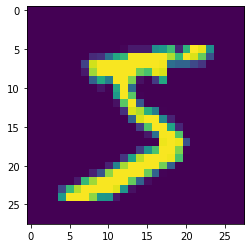

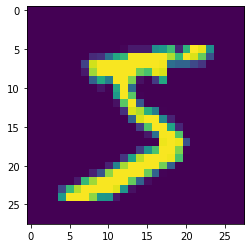

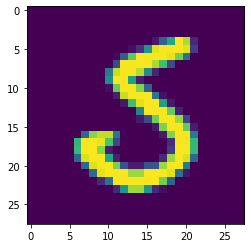

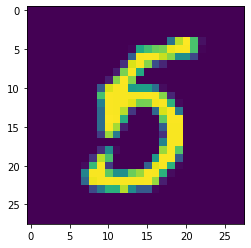

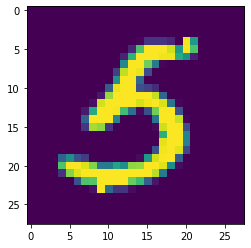

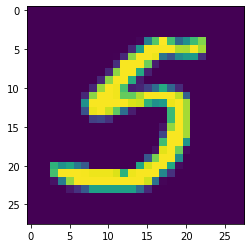

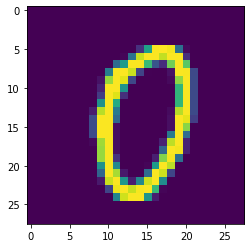

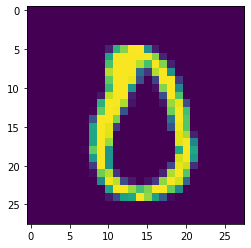

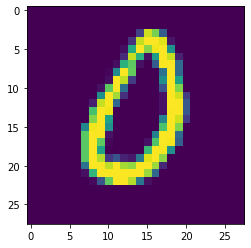

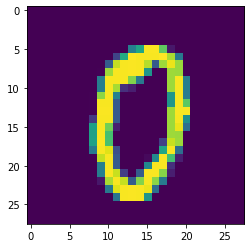

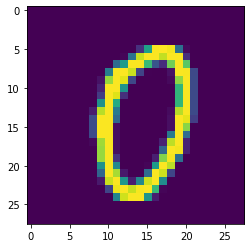

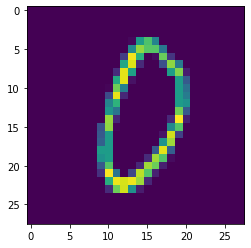

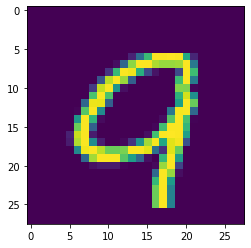

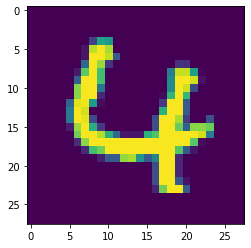

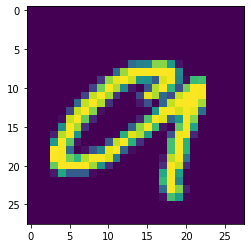

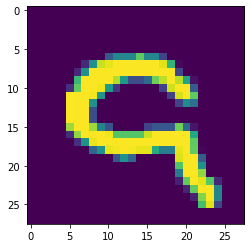

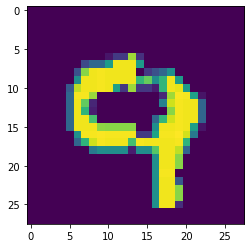

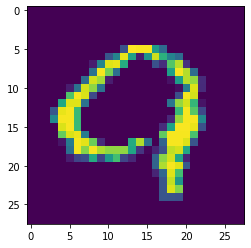

In [38]:
for idx in (0, 1000, 3000):
    kmeans.find_and_print_nn(X[idx])

Отдельной оптимизацией является умная инициализация начальных центров:
* если вы итеративно кластеризуете гомогенный набор данных, то можно использовать центры с прошлых запусков
* k-means++ - http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf
* можно кластеризовать не все данные, а некоторый семпл, если данных очень много

Заметим, что при удачном выборе количества центров, незначительное изменение (добавления и удаления) набора данных не приводит к смене 

Поиск по кластерам хорошо подходит для оффлайн подсчёта ближайших (ведь все данные удобно сложены на диск, в памяти можно хранить только центры, а затем рассматривать только нужный сабсет объектов),
особенно когда мы заранее знаем всё множество запросов (заранее считаем всех ближайших и онлайн отвечаем за `O(1)`).

Но что, если запросы заведомо неизвестны?

## k-NN index: NSW, HNSW

Для решения такой задачи с помощью K-Means мы можем построить индекс внутри каждого кластера (либо без кластеров вовсе, тут мы становимся ограничены оперативной памятью для максимизации производительности), который бы предлагал нам лучший порядок обхода объектов, чем полный перебор.

Можно было бы воспользоваться kd-tree, cover-tree, но сегодня не о них.

Другой такой структурой данных является Navigable Small World (NSW) и его идеологическое развитие Hierarchical NSW (HNSW).
Важно отметить, что всё это алгоритмы дающие приблизительный ответ (approximate nearest neighbor).

Идея, которая лежит в основе Small World, предполагает, что нам удастся построить такой граф, что расстояние между двумя любыми узлами будет расти пропорционально `log(N)`, при этом степень вершин не будет очень большой (то есть две вершины скорее всего не смежные, но достижимые за малое число шагов).

Искомый граф можно построить например следующим образом:
* Построить на всех точках граф Делоне (см https://en.wikipedia.org/wiki/Delaunay_triangulation)
* В построенный граф добавить "длинных связей" - рёбер, которые соединяют удалённые вершины, это можно делать различными методами, используя различные метрики, например, добавлять рёбра до вершин с самой большой степенью на некотором расстоянии.

![NSW](https://habrastorage.org/web/bb7/6bc/891/bb76bc89159c4a12b105071367f76c57.png)

Длинные связи обозначены красным

При этом Hierarchical Navigable Small World получается несколько иным путём: пусть нижним слоем ирерархии является исходный граф, в нём некоторым методом выделим вершины, которые образуют следующий слой, продолжая необходимое количество раз построим иерархическую структуру, где достижимость дальних участков графа регулируется глубиной и количеством связей на соответствующем уровне.

![HNSW](https://habrastorage.org/web/6a0/19a/10e/6a019a10e3fd47359f68062ca9388586.png)

Идейно, это тот же NSW, мы добавляем длинные связи к исходным вершинам, в зависимости от длины связи - попадаем на тот или иной уровень иерархии.

Свойством структуры являются глубина иерархии (q), количество связей на каждом уровне (m).

Как осуществлять поиск ближайших соседей?
Будем использовать жадный поиск в глубину в полученном графе:
* берём вершины верхнего слоя
* ищем ближайшую до запроса
* смотрим связи этой вершины на нижележащем уровне, двигаемся по слою в сторону запроса, возвращаемся к предыдущему пункту
* на нижнем слое жадно ищем соседей

Критерием остановки можно задать количество найденных, количество пройденных шагов, количество рассмотренных на нижнем уровне соседей.

Вставка новых элементов в индекс происходит путём случайного выбора максимального слоя иерархии, где будет представлена вершина, затем для каждого слоя сверху вниз добавляем связи до m ближайших, удаляем лишние связи у затронутых вершин.

https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059 - approx nearest neighbors by NSW
https://arxiv.org/ftp/arxiv/papers/1603/1603.09320.pdf - HNSW

![Статистика](https://habrastorage.org/web/c39/746/e91/c39746e918764579b369c31d8c7fe7c5.png)

Статистика из статьи Методы приближенного поиска ближайших соседей https://habr.com/ru/company/mailru/blog/338360/ (там есть некоторые продвинутые методы, почитайте)


In [40]:
! pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp38-cp38-linux_x86_64.whl size=2020317 sha256=06fa08f0b50c26bf6d623d3116369ffa73cd1ed7d189bd0091c93d30add678fb
  Stored in directory: /home/ubuntu/.cache/pip/wheels/74/3b/89/4bd924865709f24ac2df457bcca4c0b55a3eb89c5a94ce3ce8
Successfully built hnswlib


In [41]:
import hnswlib

In [42]:
class HNSWIndex():
    '''
    Принимает на вход данные (data), глубину (q), количество связей на уровне (m).
    '''
    def __init__(self, data, q, m):
        self.data = data
        self.d_shape = data.shape
        self.q = q
        self.m = m
        self._hnsw_index = self._create_index(data)
        
    def _to_1d_arr(self, x):
        if isinstance(x, sparse.csr.csr_matrix):
            x = x.toarray()
        if len(x.shape) > 1:
            x = x[0]
        assert x.shape == (self.d_shape[1],)
        return x

    def _create_index(self, data):
        hnsw = hnswlib.Index(space = 'l2', dim=data.shape[1])
        hnsw.init_index(max_elements=data.shape[0], ef_construction=self.q, M=self.m)
        hnsw.add_items(data.toarray(), range(data.shape[0]))
        return hnsw
    
    def find_nn(self, element, k=5):
        return self._hnsw_index.knn_query(self._to_1d_arr(element), k=k + 1)[0][0][1:]

    def find_and_print_nn(self, element):
        plt.figure()
        plt.imshow(element.reshape(28, 28).toarray())

        result = self.find_nn(element)
        print("Neighbours count: ", len(result))
        for nn in result[:5]:
            plt.figure()
            plt.imshow(self.data[nn].reshape(28, 28).toarray())

Neighbours count:  5
Neighbours count:  5
Neighbours count:  5


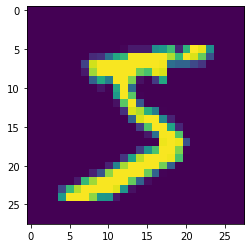

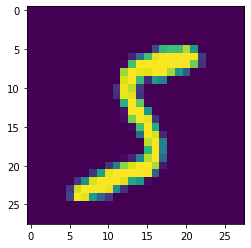

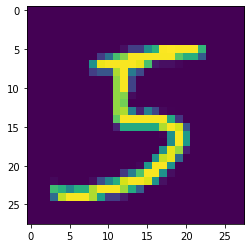

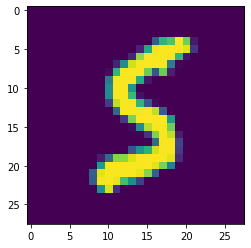

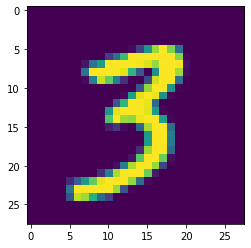

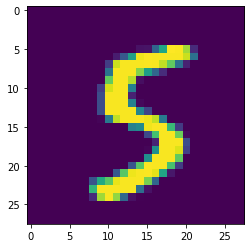

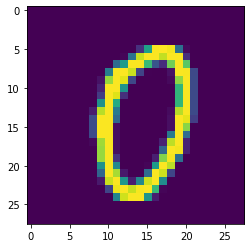

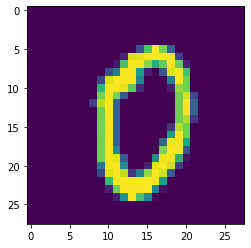

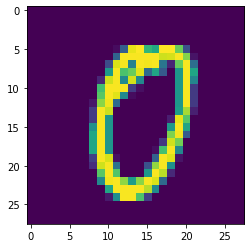

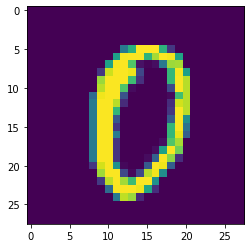

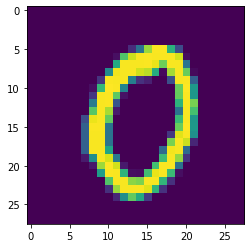

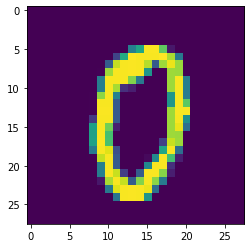

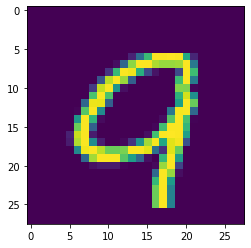

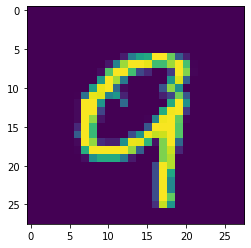

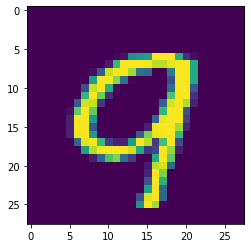

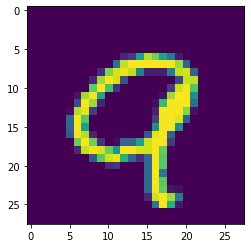

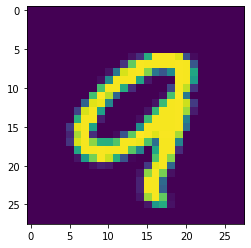

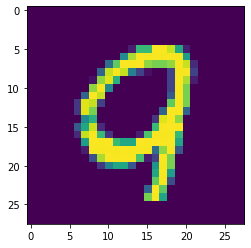

In [43]:
hnsw = HNSWIndex(X, 8, 50)
for idx in (0, 1000, 3000):
    hnsw.find_and_print_nn(X[idx])

## Точность решений

In [44]:
X_50k = X[:50000] # KMeans очень тормозной, да и все остальное занимает кучу времени
tree = BallTree(X_50k.toarray(), leaf_size=40)
lsh = CosineLSH(X_50k, 4, d=15, k=5)
kmeans = KMeansClustering(X_50k, 200, 1000)
kmeans.clusterize()
hnsw = HNSWIndex(X_50k, 8, 50)

In [45]:
np.random.seed(42)
queries = np.random.choice(X_50k.shape[0], size=300, replace=False)
SEARCH_R_SET = (4, 7, 15)

In [46]:
for r in SEARCH_R_SET:
    lsh.radius = r
    lsh_stat = []
    kmeans_stat = []
    hnsw_stat = []
    for q in queries:
        exact_result = tree.query_radius(np.array(X_50k[q].toarray()), r=7)[0]
        lsh_result = lsh.find_nn(X_50k[q], k=len(exact_result))
        kmeans_result = kmeans.find_nn(X_50k[q], k=len(exact_result))
        hnsw_result = hnsw.find_nn(X_50k[q], k=len(exact_result))
        
        lsh_stat.append(precision_recall(lsh_result, exact_result))
        kmeans_stat.append(precision_recall(kmeans_result, exact_result))
        hnsw_stat.append(precision_recall(hnsw_result, exact_result))
    
    print(f'Results with r = {r}')
    print('• CosineLSH precision {}, recall {}'.format(*np.mean(lsh_stat, axis=0)))
    print('• KMeans precision {}, recall {}'.format(*np.mean(kmeans_stat, axis=0)))
    print('• HNSW precision {}, recall {}'.format(*np.mean(hnsw_stat, axis=0)))
    print()

Results with r = 4
• CosineLSH precision 1.0, recall 0.04020151600542062
• KMeans precision 0.39654514544549374, recall 0.39654514544549374
• HNSW precision 0.9635070226361238, recall 0.9635070226361238

Results with r = 7
• CosineLSH precision 1.0, recall 0.7650835372209278
• KMeans precision 0.39654514544549374, recall 0.39654514544549374
• HNSW precision 0.9635070226361238, recall 0.9635070226361238

Results with r = 15
• CosineLSH precision 0.04950628969186393, recall 0.04941752701091497
• KMeans precision 0.39654514544549374, recall 0.39654514544549374
• HNSW precision 0.9635070226361238, recall 0.9635070226361238



Очевидным победителем является HNSW, он быстрее всех строится, быстрее находит соседей и показывает лучший результат по метрикам. Хуже всего работает KMeans – медленный в построении и неточный, хотя здесь есть место для улучшения. CosineLSH скорее всего можно подбором параметров дожать до HNSW, а так он показывает средний результат.

Что касается радиуса поиска, то тут есть смысл сравнивать только BallTree и CosineLSH, так как у других нет такого параметра. Здесь видим очевидную закономерность: чем больше радиус – тем лучше качество.